# Hyperparameter tuning using Grid Search to select the best C & Gamma for SVM classifier

Running this notebook takes too long: https://www.kaggle.com/code/sreedevirajavelu/vreed-modelling-1/edit

This notebook uses a very large range of values for C and gamma using np.logspace(), which creates a logarithmic range of values for each parameter.

By using: 

C_range = np.logspace(-2, 10, 100)

gamma_range = np.logspace(-9, 3, 100)


# Causes of Long Runtime:

Creates a logarithmic space of 100 values for each parameter. This results in a grid search space of 10,000 combinations (100 x 100)

GridSearchCV is initialized with these parameters and a 10-fold cross validation (cv=10)

SVM with an RBF kernel (Radial Basis Function) can be computationally expensive. Each model training involves a solving a quadratic optimization problem, which can be slow.


# Solutions to reduce runtime:

**1. Reduce Parameter Grid:**

Use a coarser grid (eg. 10 values each). Can perform random search or use successive halving to optimize the search process

**2. Use fewer cross-validation folds:**

Reduce cross-validation folds from 10 to 5


**3. Sample the data:**

If dataset is large, work with a subset of the data to perform grid search

**4. Parallelize Grid Search:
**
**GridSearchCV** supports parallel processing with the **n_jobs** **parameter**. 

Setting **n_jobs = -1 ** would utilize all available CPU cores to run multiple cores simultaneously.




In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

#from skl2onnx import convert_sklearn
#from skl2onnx.common.data_types import FloatTensorType, StringTensorType

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Hyperparameter Tuning using Grid Search

To search for the best set of hyperparameters for SVM classifier

# Split categories into arousal level

* 0=High Arousal High Valence, 
* 1=Low Arousal High Valence, 
* 2=Low Arousal Low Valence, 
* 3=High Arousal Low Valence

In [2]:

# C_range = np.logspace(-2, 10, 10)
# gamma_range = np.logspace(-9, 3, 10)
# param_grid = dict(gamma=gamma_range, C=C_range)
        
eyedata_file_path = '/kaggle/input/vr-eyes-emotions-dataset-vreed/04 Eye Tracking Data/02 Eye Tracking Data (Features Extracted)/EyeTracking_FeaturesExtracted.csv'
eye_data = pd.read_csv(eyedata_file_path) 

print('-------------------  SHAPE OF EYE DATA FEATURES EXTRACTED CSV ------------------')
print(eye_data.shape)

print('-------------------  LEN OF EYE DATA FEATURES EXTRACTED CSV ------------------')
print(len(eye_data))

eye_data.columns

print(eye_data.head)


print('-------------------  eye_data[Quad_cat] ------------------')
print(eye_data['Quad_Cat'])
print(eye_data['Quad_Cat'].unique())


y = eye_data.Quad_Cat

eye_data_features = ['Num_of_Fixations', 'Mean_Fixation_Duration',
       'SD_Fixation_Duration', 'Skew_Fixation_Duration',
       'Max_Fixation_Duration', 'First_Fixation_Duration', 'Num_of_Saccade',
       'Mean_Saccade_Duration', 'SD_Saccade_Duration', 'Skew_Saccade_Duration',
       'Max_Saccade_Duration', 'Mean_Saccade_Amplitude',
       'SD_Saccade_Amplitude', 'Skew_Saccade_Amplitude',
       'Max_Saccade_Amplitude', 'Mean_Saccade_Direction',
       'SD_Saccade_Direction', 'Skew_Saccade_Direction',
       'Max_Saccade_Direction', 'Mean_Saccade_Length', 'SD_Saccade_Length',
       'Skew_Saccade_Length', 'Max_Saccade_Length', 'Num_of_Blink',
       'Mean_Blink_Duration', 'SD_Blink_Duration', 'Skew_Blink_Duration',
       'Max_Blink_Duration', 'Num_of_Microsac', 'Mean_Microsac_Peak_Vel',
       'SD_Microsac_Peak_Vel', 'Skew_Microsac_Peak_Vel',
       'Max_Microsac_Peak_Vel', 'Mean_Microsac_Ampl', 'SD_Microsac_Ampl',
       'Skew_Microsac_Ampl', 'Max_Microsac_Ampl', 'Mean_Microsac_Dir',
       'SD_Microsac_Dir', 'Skew_Microsac_Dir', 'Max_Microsac_Dir',
       'Mean_Microsac_H_Amp', 'SD_Microsac_H_Amp', 'Skew_Microsac_H_Amp',
       'Max_Microsac_H_Amp', 'Mean_Microsac_V_Amp', 'SD_Microsac_V_Amp',
       'Skew_Microsac_V_Amp', 'Max_Microsac_V_Amp']




-------------------  SHAPE OF EYE DATA FEATURES EXTRACTED CSV ------------------
(312, 50)
-------------------  LEN OF EYE DATA FEATURES EXTRACTED CSV ------------------
312
<bound method NDFrame.head of      Quad_Cat  Num_of_Fixations  Mean_Fixation_Duration  SD_Fixation_Duration  \
0           1          0.605556             1208.440367           1013.049251   
1           0          0.459184             1796.311111           1880.259542   
2           0          0.480000             1617.694444           1895.391401   
3           3          0.454545             1858.763636           2711.244828   
4           1          0.527778             1582.126316           1520.578818   
..        ...               ...                     ...                   ...   
307         2          0.448276             2023.403846           2121.443120   
308         0          0.278146             3123.047619           3834.811402   
309         1          0.490683             1419.607595           1

# Preprocessing step: Handle missing data

SimpleImputer is used to fill missing values in the feature matrix X.

Replaces any missing values (NaN) with the mean of the respective column

In [3]:
X = eye_data[eye_data_features]

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X_imp = imp.transform(X)


# Perform GridSearchCV with 5 folds of cross validation and find best set of parameters for SVM classifier

In [4]:
# gs_knn = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=5) # perform GridSearch with 5 fold cross validation

# X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.1, random_state=0)

# gs_knn.fit(X_train, y_train)
# gs_knn.best_params_

# #print("Ground Truth: " + str(eye_data.iloc[5].Quad_Cat))
# #print("Inference: " + str(test[0]))

# # find best model score
# gs_knn.score(X_test, y_test)


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

# load and process data
# eye tracking features and target variable

# X = eye_data[eye_data_features]
# y = eye_data.Quad_Cat

# # handle missing values 
# imp = SimpleImputer(missing_values=np.nan , strategy ='mean')
# X_imp = imp.fit_transform(X)

# train test split
X_train, X_test , y_train , y_test = train_test_split(X_imp, y , test_size=0.2,random_state=0)

classifiers = {
    'SVM':SVC(),
    'Random Forest':RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'Naive Bayes': GaussianNB()
    
}


# use StratifiedKFold to ensure class proportions are preserved in each fold
cross_val = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# to store the mean cross-validation accuracies
mean_accuracies = []

for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    
    # perform 5 Fold Cross-validation on the training data
    cv_scores = cross_val_score(clf, X_train,y_train , cv = cross_val , scoring='accuracy') 
        
    # print the accuracy of each fold
    for i, score in enumerate(cv_scores):
          print(f"Fold {i+1} Accuracy: {score * 100:.2f}%")
          
    # mean accuracy across all folds 
    mean_cv_accuracy = np.mean(cv_scores)
    mean_accuracies.append(mean_cv_accuracy * 100) # save mean accuracy to plot and compare
    print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy * 100:.2f}%")
          
    # train the classifier on the entire training set and evaluate on the test set
    clf.fit(X_train , y_train)
    y_test_pred = clf.predict(X_test)
    
    # confusion matrix and accuracy on the test set
    test_cm = confusion_matrix(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test , y_test_pred)
    print(f"Confusion Matrix (Test Set):\n{test_cm}")
    print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")      
          


Classifier: SVM
Fold 1 Accuracy: 40.00%
Fold 2 Accuracy: 42.00%
Fold 3 Accuracy: 32.00%
Fold 4 Accuracy: 30.00%
Fold 5 Accuracy: 26.53%
Mean Cross-Validation Accuracy: 34.11%
Confusion Matrix (Test Set):
[[ 0 10  6  4]
 [ 0  7  2  5]
 [ 0  6  5  5]
 [ 2  6  2  3]]
Test Set Accuracy: 23.81%

Classifier: Random Forest
Fold 1 Accuracy: 52.00%
Fold 2 Accuracy: 64.00%
Fold 3 Accuracy: 60.00%
Fold 4 Accuracy: 62.00%
Fold 5 Accuracy: 40.82%
Mean Cross-Validation Accuracy: 55.76%
Confusion Matrix (Test Set):
[[ 9  5  2  4]
 [ 2  9  1  2]
 [ 2  1 11  2]
 [ 3  1  4  5]]
Test Set Accuracy: 53.97%

Classifier: K-Nearest Neighbors
Fold 1 Accuracy: 38.00%
Fold 2 Accuracy: 32.00%
Fold 3 Accuracy: 34.00%
Fold 4 Accuracy: 36.00%
Fold 5 Accuracy: 38.78%
Mean Cross-Validation Accuracy: 35.76%
Confusion Matrix (Test Set):
[[9 5 5 1]
 [2 7 3 2]
 [4 6 5 1]
 [6 4 3 0]]
Test Set Accuracy: 33.33%

Classifier: Decision Tree
Fold 1 Accuracy: 42.00%
Fold 2 Accuracy: 32.00%
Fold 3 Accuracy: 32.00%
Fold 4 Accuracy

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fold 1 Accuracy: 42.00%
Fold 2 Accuracy: 60.00%
Fold 3 Accuracy: 42.00%
Fold 4 Accuracy: 58.00%
Fold 5 Accuracy: 40.82%
Mean Cross-Validation Accuracy: 48.56%


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix (Test Set):
[[4 7 0 9]
 [2 7 0 5]
 [3 3 7 3]
 [6 1 1 5]]
Test Set Accuracy: 36.51%

Classifier: Gradient Boosting
Fold 1 Accuracy: 46.00%
Fold 2 Accuracy: 60.00%
Fold 3 Accuracy: 56.00%
Fold 4 Accuracy: 62.00%
Fold 5 Accuracy: 40.82%
Mean Cross-Validation Accuracy: 52.96%
Confusion Matrix (Test Set):
[[ 8  5  1  6]
 [ 1  7  1  5]
 [ 0  3 13  0]
 [ 4  4  1  4]]
Test Set Accuracy: 50.79%

Classifier: AdaBoost
Fold 1 Accuracy: 40.00%
Fold 2 Accuracy: 46.00%
Fold 3 Accuracy: 40.00%
Fold 4 Accuracy: 60.00%
Fold 5 Accuracy: 26.53%
Mean Cross-Validation Accuracy: 42.51%
Confusion Matrix (Test Set):
[[4 6 2 8]
 [1 5 3 5]
 [0 4 5 7]
 [2 5 0 6]]
Test Set Accuracy: 31.75%

Classifier: Naive Bayes
Fold 1 Accuracy: 40.00%
Fold 2 Accuracy: 46.00%
Fold 3 Accuracy: 38.00%
Fold 4 Accuracy: 42.00%
Fold 5 Accuracy: 46.94%
Mean Cross-Validation Accuracy: 42.59%
Confusion Matrix (Test Set):
[[ 3 10  5  2]
 [ 0  7  6  1]
 [ 0  3 12  1]
 [ 4  1  5  3]]
Test Set Accuracy: 39.68%


# Plot cross-validation accuracies for all classifiers

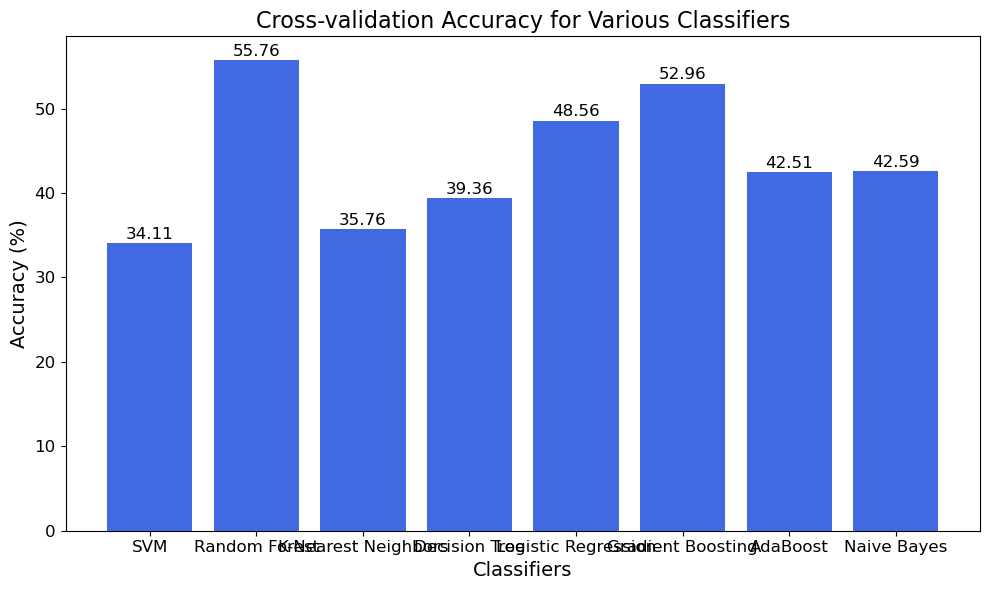

In [6]:
# plot the mean cross validation accuracies
classifier_names = list(classifiers.keys())
y_pos = np.arange(len(classifier_names))

plt.figure(figsize=(10,6))
plt.bar(y_pos , mean_accuracies , color='royalblue')

# add text labels for each bar
for index, value in enumerate(mean_accuracies):
    plt.text(index , value+0.5 , str(np.round(value , 2)), ha='center',fontsize=12, color='black')

# set the tick labels, titles and labels
plt.xticks(y_pos , classifier_names, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('Classifiers', fontsize=14)
plt.title('Cross-validation Accuracy for Various Classifiers' , fontsize=16)

# show plot
plt.tight_layout()
plt.show()
